# HW6

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrsteamedbun/AIPI590/blob/main/HW6/hw6.ipynb)

In [ ]:
!pip install numpy==1.25.2 pandas==2.0.3 scikit-learn==1.2.2 shap==0.45.1 xgboost==1.7.5 pdpbox
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

**Dataset** We will use the [California Housing Prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices). This is the median house prices for California districts derived from the 1990 census.

**Model** We will train an Random Forest Regressor model with n_estimators=100, random_state=42.

In [ ]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay

# XAI
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from pdpbox import pdp

Load the dataset and train the model.

In [ ]:
# Load dataset
housing = fetch_california_housing()
data = pd.DataFrame(housing.data, columns=housing.feature_names)
data['MedHouseVal'] = housing.target

# Split data into train and test
X = data.drop(columns=['MedHouseVal'])
y = data['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

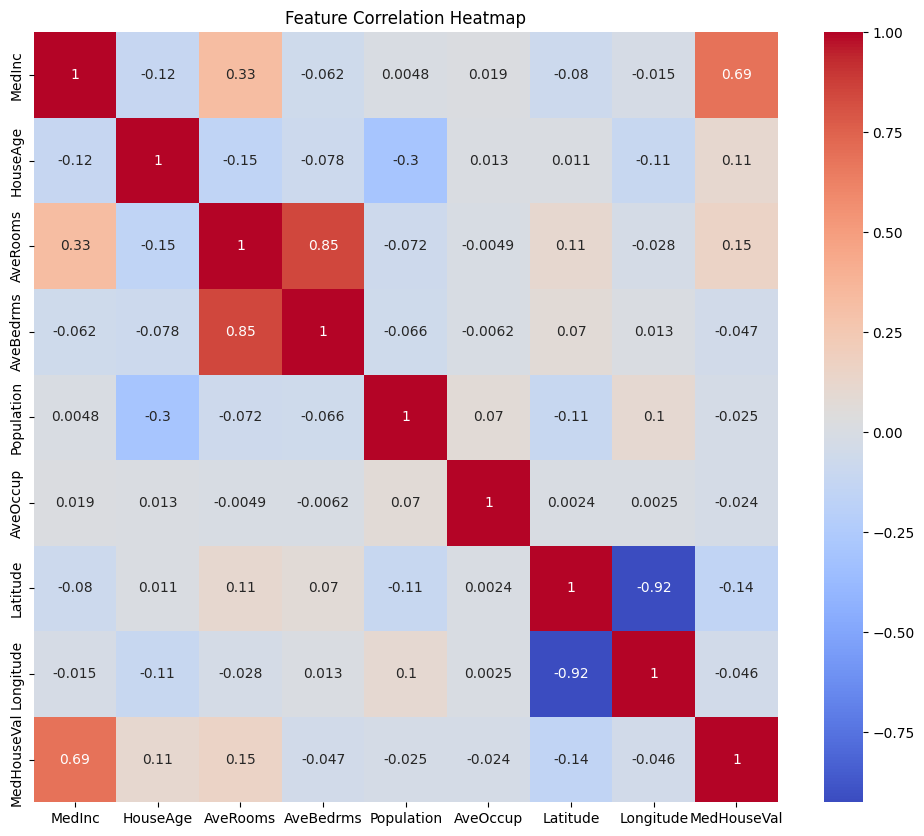

In [ ]:
# Exploratory Analysis
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

## Partial Dependence Plots (PDP)

The PDP represents the average effect of "AveRooms" on the model’s prediction by marginalizing over all other features. It assumes feature independence, which can lead to unrealistic effects when features are correlated.


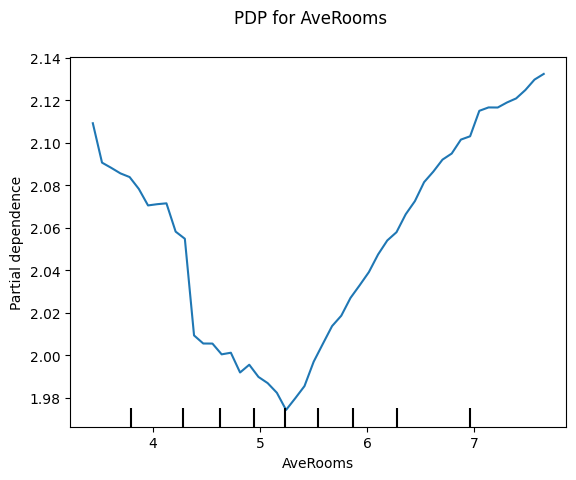

In [12]:
features = ['AveRooms']
PartialDependenceDisplay.from_estimator(model, X_train, features, kind='average', grid_resolution=50)
plt.suptitle('PDP for AveRooms')
plt.show()

* In the PDP, we see a U-shaped trend. The average prediction decreases slightly between 4 and 5 rooms, reaching a minimum at around 5 rooms, and then starts to increase again.
* This suggests that on average, an increase in "AveRooms" initially lowers the prediction slightly but then increases it for higher values. This trend is more global since it takes into account the average effect across all instances, unlike ALE and ICE which are more localized.

## ICE Plots

ICE plots demonstrate the effect of a single feature, "AveRooms," on the model's prediction for each instance in the dataset. Each line represents a different data instance, showing how the prediction changes as the feature value changes.

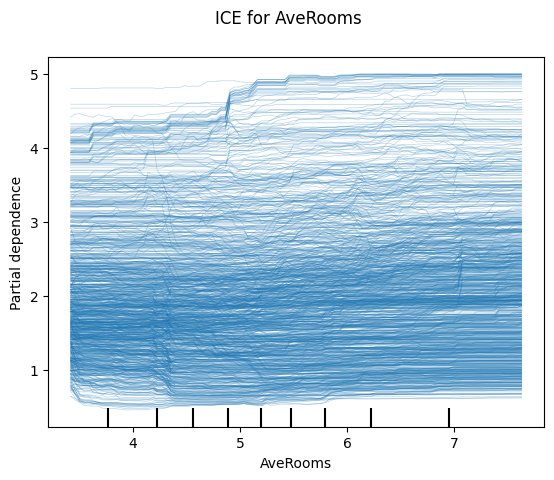

In [13]:
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='individual')
plt.suptitle('ICE for AveRooms')
plt.show()

* In the ICE plot, most lines show a relatively steady increase after a certain point (around 5 rooms), meaning that for many data points, the prediction increases as the number of average rooms increases.
* The differences in line slopes suggest that "AveRooms" has a heterogeneous impact on predictions, with some instances being more sensitive to changes in "AveRooms" than others.
* The sharp transition in certain lines (around 5 rooms) indicates that for some instances, a threshold effect exists where the prediction changes suddenly. This might suggest the presence of interactions with other features.

## ALE Plots  

ALE plots show the local effect of "AveRooms" on predictions, accounting for the correlation between features. ALE doesn't assume feature independence, making it more reliable when features interact or are correlated.


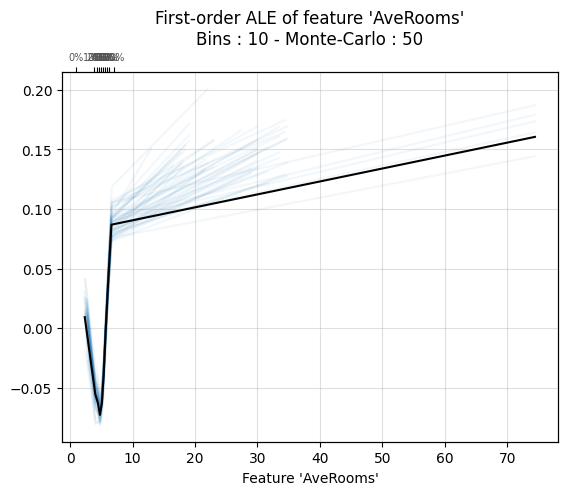

<Figure size 640x480 with 0 Axes>

In [14]:
ale_plot(model, X_train, 'AveRooms', monte_carlo=True)

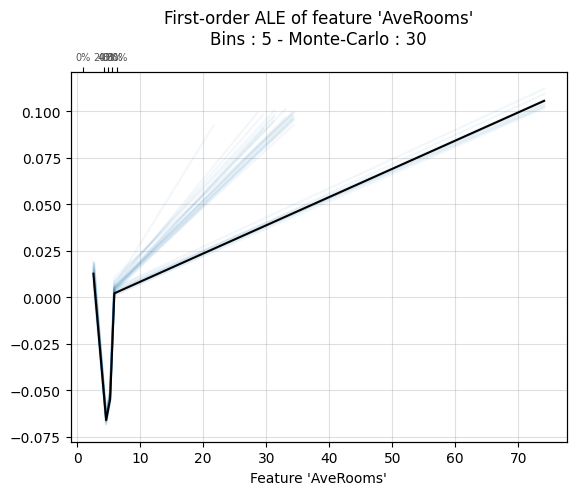

<Axes: title={'center': "First-order ALE of feature 'AveRooms'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'AveRooms'">

In [ ]:
ale_plot(
    model,
    X_train,
    'AveRooms',
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

* In the ALE plot, we can observe that the overall effect of "AveRooms" increases as the number of rooms increases. The ALE line trends upwards, especially for values beyond 10 rooms, indicating that increasing "AveRooms" results in higher predictions.
* The ALE curve is more gradual and smooth compared to the ICE plot. This happens because ALE accounts for feature interactions, meaning the plot represents more realistic scenarios (i.e., how the feature behaves with others).

## Discussion
#### PDP vs ALE
* The PDP shows a U-shaped curve, whereas the ALE plot is more linear and steadily increases. The difference arises from the assumptions about feature independence.
* PDP assumes independence of "AveRooms" from other features, which might lead to an over-simplified or even unrealistic depiction of the feature's impact.
ALE accounts for correlations and interactions, providing a more accurate picture when features are correlated. This explains why ALE shows a more consistent upward trend while PDP shows a dip followed by an increase.

The differences between ICE and ALE suggest the presence of interaction effects. Some individual instances (as shown in the ICE plot) have sudden changes at around 5 rooms, which is also reflected as the turning point in the PDP. However, ALE’s smoother increase suggests that these interactions are more complex and perhaps dependent on other features in the dataset.

Since ALE adjusts for correlation and interaction effects, the more gradual trend of the ALE plot indicates that "AveRooms" generally has a positive effect on predictions, but this effect becomes more noticeable at higher values. This contrasts with the U-shaped curve in the PDP, which doesn’t account for potential correlations.